In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple

In [2]:
np.set_printoptions(precision=6, suppress=True)
rng = np.random.default_rng(78787)
tenors = np.array([0.5, 1, 2, 3, 5, 7, 10, 15])
y_cc = np.array([0.03, 0.032, 0.035, 0.037, 0.04, 0.042, 0.045, 0.047])
B0 = np.exp(-y_cc * tenors)

In [3]:
# linear interpolation
def B0_of(T: float) -> float:
    if T <= 0: 
        return 1
    return float(np.interp(T, tenors, B0))

def f0_of(t: float, eps: float=1e-4) -> float:
    # symetry
    t1 = max(t - eps, 1e-6)
    t2 = t + eps
    return - (np.log(B0_of(t2)) - np.log(B0_of(t1))) / (t2 - t1)

In [4]:
def beta(t, T, a):
    return (1 - np.exp(-a*(T - t))) / a

def alpha(t, T, a, sigma):
    # curve-consistent
    b = beta(t, T, a)
    term = (sigma**2)/(4*a) * (1 - np.exp(-2*a*t)) * b*b
    # log-form for stability
    log_alpha = np.log(B0_of(T)) - np.log(B0_of(t)) + b * f0_of(t) - term
    return np.exp(np.clip(log_alpha, -700, 700))

def bond_price_HW(t, T, r_t, a, sigma):
    b = beta(t, T, a)
    log_alpha = np.log(alpha(t, T, a, sigma))
    logB = log_alpha - b * r_t
    return np.exp(np.clip(logB, -700, 700))

def theta_t(t, a, sigma):
    return ( (f0_of(t + 1e-4) - f0_of(t - 1e-4)) / (2e-4) 
            + a * f0_of(t) + (sigma**2)/(2*a)*(1 - np.exp(-2*a*t)) )

def sigma_P_sq(t, T, S, a, sigma):
    # for caplet and zc options
    delta = S - T
    return (sigma**2 / a**2) * (np.exp(-a*delta) - 1)**2 * (1 - np.exp(-2*a*(T - t))) / (2*a)

def ATM_swaption_black_vol_HW(T, n, delta, a, sigma) -> float:
    # Couderc
    B_list = np.array([B0_of(T + (i+1)*delta) for i in range(n)])
    w = B_list / np.sum(B_list)
    wprime = B0_of(T + n*delta) / (B0_of(T) - B0_of(T + n*delta))
    term = np.sum(w * (1 - np.exp(-a * np.arange(1, n+1)*delta))) + wprime * (1 - np.exp(-a * n * delta))
    vol_sq = (sigma**2 / a**2) * term**2 * (1 - np.exp(-2*a*T)) / (2*a*T)
    return np.sqrt(max(vol_sq, 0))

In [5]:
# synthetic ATM swaption vols
a_true, sigma_true = 0.03, 0.01
maturities = np.array([1, 2, 5]) 
n_pay = np.array([4, 6, 10])
delta = 0.5

In [6]:
atm_vol_mkt = np.array([ATM_swaption_black_vol_HW(T, n, delta, a_true, sigma_true)
                        for T, n in zip(maturities, n_pay)])

In [7]:
def calib_error(params):
    a, sigma = params
    model = np.array([ATM_swaption_black_vol_HW(T, n, delta, a, sigma)
                      for T, n in zip(maturities, n_pay)])
    return np.sum((model - atm_vol_mkt)**2)

# grid search basically
agrid = np.linspace(0.01, 0.1, 30)
sgrid = np.linspace(0.005, 0.03, 30)
best = (None, 1000000000)
for a in agrid:
    for s in sgrid:
        err = calib_error((a, s))
        if err < best[1]:
            best = ((a, s), err)
a_hat, sigma_hat = best[0]
print(f"Calibrated a={a_hat:.4f}, sigma={sigma_hat:.4f}    (true a={a_true:.4f}, sigma={sigma_true:.4f})")

Calibrated a=0.0348, sigma=0.0102    (true a=0.0300, sigma=0.0100)


In [8]:
# int rate swap exposure
@dataclass
class IRS:
    notional: float
    fixed_rate: float
    pay_freq: float   # in years (e.g. 0.5)
    start: float
    maturity: float

In [9]:
def simulate_HW_paths_factor(a, sigma, T, dt, n_paths):
    times = np.arange(0, T+dt, dt)
    x = np.zeros((len(times), n_paths))
    k = np.exp(-a*dt)
    s2 = (sigma**2)/(2*a) * (1 - np.exp(-2*a*dt))
    for i in range(1, len(times)):
        x[i,:] = k * x[i-1,:] + np.sqrt(s2) * rng.standard_normal(n_paths)
    r = np.zeros_like(x)
    for i, t in enumerate(times):
        r[i,:] = f0_of(t) + x[i,:]
    return times, r

def annuity_at(t, T1, n, delta, r_t, a, sigma):
    # sum of disc. ZC from T1+delta to T1+n*delta
    pay_dates = [T1 + (i+1)*delta for i in range(n)]
    return sum(bond_price_HW(t, u, r_t, a, sigma) for u in pay_dates)

def IRS_value(t, r_t, irs: IRS, a, sigma):
    # PV of fixed minus float for a payer swap
    n = int(round((irs.maturity - irs.start)/irs.pay_freq))
    A = annuity_at(t, irs.start, n, irs.pay_freq, r_t, a, sigma)
    float_leg = 1 - bond_price_HW(t, irs.maturity, r_t, a, sigma)
    fixed_leg = irs.fixed_rate * A
    return irs.notional * (fixed_leg - float_leg)

In [10]:
# set up simulation and contract
T_horizon = 10
dt = 1/12  # monthly
n_paths = 20000
times, rpaths = simulate_HW_paths_factor(a_hat, sigma_hat, T_horizon, dt, n_paths)
irs = IRS(notional=1, fixed_rate=0.045, pay_freq=0.5, start=2, maturity=7)

In [11]:
values = np.zeros((len(times), n_paths))
for i, t in enumerate(times):
    r_t = rpaths[i,:]
    values[i,:] = IRS_value(t, r_t, irs, a_hat, sigma_hat)

def exposure_stats(v):
    # positive exposure only for the sake of reporting standards
    pe = np.maximum(v, 0)
    ee = pe.mean()
    pfe95 = np.quantile(pe, 0.95)
    return ee, pfe95

EPE ~ 0.390468


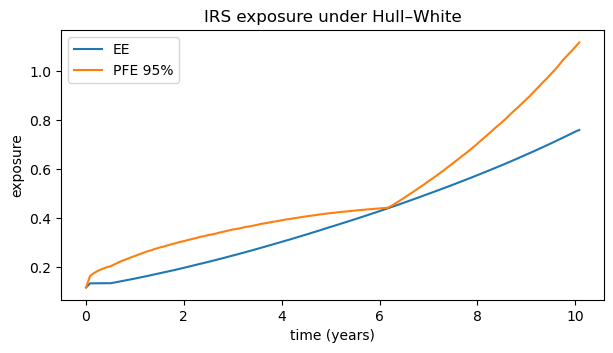

In [12]:
EE = []
PFE95 = []
for i in range(len(times)):
    ee, pfe = exposure_stats(values[i,:])
    EE.append(ee)
    PFE95.append(pfe)
EE = np.array(EE)
PFE95 = np.array(PFE95)
EPE = np.trapz(EE, times) / times[-1]
print(f"EPE ~ {EPE:0.6f}")
plt.figure(figsize=(7, 3.5))
plt.plot(times, EE, label="EE")
plt.plot(times, PFE95, label="PFE 95%")
plt.xlabel("time (years)")
plt.ylabel("exposure")
plt.legend()
plt.title("IRS exposure under Hull–White")
plt.show()

In [ ]:
# The exposure increases over time because the Hull–White model allows the short rate to revert slowly
# the present value of the receiver leg of the swap becomes increasingly sensitive to rate movements as maturity approaches. 
#The expected exposure (EE) grows smoothly, while the PFE 95% lies above it, reflecting the tail risk of interest rate scenarios
# Although very toy example, exposure tends to rise as the remaining floating payments decrease and the position behaves like a longer-duration bond.